In [2]:
%load_ext autoreload
%autoreload 2
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import sys
sys.path.insert(0, "../scripts/trimap_generation/")
sys.path.insert(0, "../scripts/")
from saliency import get_saliency_fine_grained
import cv2 as cv
from matplotlib.pyplot import imshow
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from trimap import generate_trimap
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
T1 = 0.25

In [4]:
image = cv.imread("../images/person.jpg")

In [6]:
image2 = Image.open("../images/person.jpg")

In [3]:
image3 = cv.imread("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\beach-747750_1280_15.jpg")

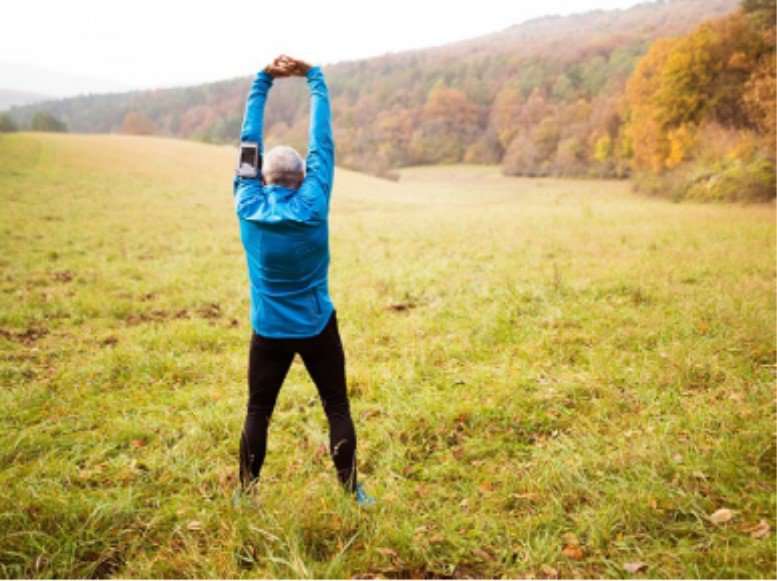

In [7]:
image2

In [15]:
saliency = get_saliency_fine_grained(image)

In [78]:
segments = slic(image, n_segments = 400, compactness=10)

In [235]:
np.max(segments)

330

In [268]:
np.sum(segments==150)

1187

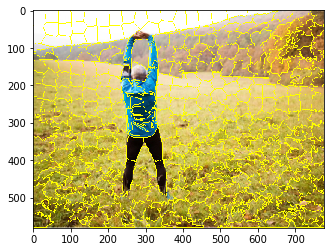

In [79]:
imshow(mark_boundaries(cv.cvtColor(image, cv.COLOR_BGR2RGB), segments), cmap="gray")

In [30]:
def get_median_superpixel(saliency, segments):
    n_segments = np.max(segments) + 1
    medians = []
    for segment_idx in range(n_segments):
        x, y = np.where(segments==segment_idx)
        current_superpixel_values = []
        for i, j in zip(x, y):
            current_superpixel_values.append(saliency[i, j])
        medians.append(np.median(current_superpixel_values))
    return medians

In [269]:
medians = get_median_superpixel(1-saliency/255, segments)

In [73]:
test = np.zeros((2, 2))

In [6]:
def set_value_for_superpixel(saliency, segment_indices, value):
    for x, y in segment_indices:
        saliency[x, y] = value
    

In [7]:
def classify_superpixels_based_on_median_of_saliency(saliency, segments, medians):
    sal = saliency.copy()
    classes = []
    for index, median in enumerate(medians):
        segment_indices = zip(*np.where(segments==index))
        classification = 0 if median < T1 else 1
        set_value_for_superpixel(sal, segment_indices, classification)
        classes.append(classification)
    return sal, np.array(classes)

In [270]:
sal, classes = classify_superpixels_based_on_median_of_saliency(1 - saliency/255, segments, medians)

In [62]:
x, y = np.where(segments==56)
for i, j in zip(x, y):
    saliency[i, j] = 0

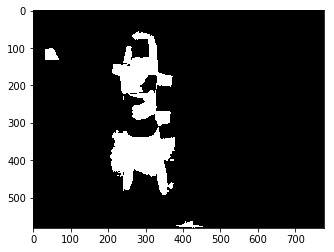

In [276]:
imshow(sal, cmap="gray")

In [223]:
sift = cv.xfeatures2d.SIFT_create()

In [134]:
orb = cv.ORB_create(nfeatures=1500)

In [112]:
key_point = cv.KeyPoint(x=10, y=10, _size=10)

In [140]:
_, desc = sift.compute(1 - saliency, keypoints=[key_point], descriptors=None)

In [126]:
keypoints, descriptors = sift.detectAndCompute(image, None)

In [103]:
img = cv.drawKeypoints(image, keypoints, None)

In [141]:
desc

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   4., 169.,   0.,   0.,   0.,   0.,   0.,   0.,   6., 169.,
          3.,   0.,   0.,   0.,   0.,   0.,   3., 169.,  19.,   0.,   0.,
          0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,
         18., 169.,   0.,   0.,   0.,   0.,   0.,   0.,  26., 169.,   0.,
          0.,   0.,   0.,   0.,   0.,  26., 169.,  12.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,  28.,
        169.,   0.,   0.,   0.,   0.,   0.,   0.,  31., 169.,   0.,   0.,
          0.,   0.,   0.,   0.,  21., 169.,   1.]], dtype=float32)

In [8]:
def get_descriptor_for_each_superpixel(image, segments, descriptor_method, patch_size):
    n_segments = np.max(segments) + 1
    descriptors = np.empty((n_segments, 128))
    for segment_idx in range(n_segments):
        x, y = np.where(segments==segment_idx)
        x_avg = np.average(x)
        y_avg = np.average(y)
        
        key_point = cv.KeyPoint(x=x_avg, y=y_avg, _size=patch_size)
        _, desc = descriptor_method.compute(image, keypoints=[key_point], descriptors=None)
        descriptors[segment_idx, :] = desc
    return descriptors

In [9]:
def get_bhat_d_for_each_pair_superpixels(image, segments):
    n_segments = np.max(segments) + 1
    distances = np.empty((n_segments, n_segments))
    for i in range(n_segments):
        for j in range(n_segments):
            if i > j:
                continue
            d = get_bhat_distance(image, segments, i, j)
            distances[i, j] = d
            distances[j, i] = d
    return distances

In [10]:
def get_bhat_d_for_each_pair_superpixels_fast(hists):
    hist_r = hists[0]
    hist_g = hists[1]
    hist_b = hists[2]
    n_superpixels = len(hist_r)

    distances = np.empty((n_superpixels, n_superpixels))
    for i in range(n_superpixels):
        for j in range(n_superpixels):
            if i > j:
                continue
            hist_i = [hist_r[i], hist_g[i], hist_b[i]]
            hist_j = [hist_r[j], hist_g[j], hist_b[j]]
            dist = per_color_bhatt_d(hist_i, hist_j)
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

In [61]:
all_hists[0][0]

array([0.00058481, 0.00265369, 0.00705195, 0.01919437, 0.0286117 ,
       0.0362133 , 0.04961681, 0.05900426, 0.07077641, 0.08216871,
       0.09488151, 0.09373522, 0.08775813, 0.06823409, 0.0450383 ,
       0.03467346, 0.02562534, 0.01838592, 0.0151921 , 0.01939128,
       0.0200946 , 0.04020668, 0.02313706, 0.01410698, 0.0110259 ,
       0.00978452, 0.01245411, 0.00456331, 0.00309801, 0.00181991,
       0.00057355, 0.000344  ])

In [74]:
dists = get_bhat_d_for_each_pair_superpixels_fast(hists)

In [76]:
dists.shape

(378, 378)

In [595]:
dist = get_bhat_d_for_each_pair_superpixels(image, segments)

In [585]:
np.seterr(all='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [583]:
dist[np.isnan(dist)]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [277]:
descs = get_descriptor_for_each_superpixel(image, segments, sift, 40)

In [278]:
descs

array([[  0.,   0.,   0., ...,  19., 133.,  25.],
       [  0.,   0.,   0., ...,  26., 159.,  33.],
       [  0.,   0.,   0., ...,  15.,  95.,  30.],
       ...,
       [ 14.,  17.,  82., ...,  26.,  49.,  13.],
       [  9.,  14.,  22., ...,  40.,  51.,  39.],
       [ 16.,  22.,  28., ...,  42.,  37.,  27.]])

In [11]:
def get_indices_of_fg_bg_superpixels(classes):
    fg_indices = np.where(classes==1)[0]
    bg_indices = np.where(classes==0)[0]
    return fg_indices, bg_indices

In [153]:
fg, bg = get_indices_of_fg_bg_superpixels(classes)

In [181]:
fg[0]

array([ 11,  45,  73,  85, 102, 111, 117, 127, 128], dtype=int64)

In [160]:
kmeans = KMeans(n_clusters=5)

In [163]:
kmeans.fit_predict(descs[fg])

array([2, 1, 4, 3, 0, 0, 1, 1, 1])

In [165]:
kmeans.cluster_centers_.shape

(5, 128)

In [166]:
kk = np.zeros((2,2))
for row in kk:
    print(row)

[0. 0.]
[0. 0.]


In [12]:
def mean_distance_to_every_center(points, centers):
    distances = []
    for point in points:
        for center in centers:
            dist = np.linalg.norm(point-center) #euclidian distance
            distances.append(dist)
    return np.median(np.array(distances))

In [168]:
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [69]:
hists[0].shape

(378, 32)

In [597]:
dist.shape

(378, 378)

In [13]:
def calc_avg_distance_to_centers(point, centers):
    distances = []
    for center in centers:
        dist = np.linalg.norm(point-center)
        distances.append(dist)
    return np.median(np.array(distances))

In [603]:
dist[fg][:, fg].shape

(27, 27)

In [628]:
dbscan  = DBSCAN()
# sift = cv.xfeatures2d.SIFT_create()
segments = slic(image, n_segments = 400, compactness=20)
medians = get_median_superpixel(1-saliency/255, segments)
sal, classes = classify_superpixels_based_on_median_of_saliency(1 - saliency/255, segments, medians)
# descs = get_descriptor_for_each_superpixel(image, segments, sift, 40)
fg, bg = get_indices_of_fg_bg_superpixels(classes)
dbscan = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)
dbscan.fit(dist[fg][:, fg])
dbscan.labels_

array([ 0,  1,  1, -1,  1,  0,  0, -1,  1,  2, -1,  2, -1,  3,  0,  3,  0,
        0,  0,  3,  3,  0,  0,  3,  3,  3,  3], dtype=int64)

In [576]:
from nltk.cluster.kmeans import KMeansClusterer


In [14]:
def clusterize_superpixels(dists, classes):
    fg, bg = get_indices_of_fg_bg_superpixels(classes)
    dbscan = DBSCAN(metric="precomputed")
    dbscan.fit(dists[fg])

In [15]:
def clusterize_superpixels(descs, classes):
    fg, bg = get_indices_of_fg_bg_superpixels(classes)
    kmeans_fg = KMeans(n_clusters=5)
    kmeans_bg = KMeans(n_clusters=5)
    
    clusters_fg = kmeans_fg.fit_predict(descs[fg])
    clusters_bg = kmeans_bg.fit_predict(descs[bg])
    
    cluster_centers_fg = kmeans_fg.cluster_centers_
    cluster_centers_bg = kmeans_bg.cluster_centers_
    
    t2_fg = mean_distance_to_every_center(descs[fg], cluster_centers_bg) 
    t2_bg = mean_distance_to_every_center(descs[bg], cluster_centers_fg) 
    
#     print(mean_distance_to_every_center(descs[fg], cluster_centers_fg))
#     print(mean_distance_to_every_center(descs[bg], cluster_centers_bg))
    new_fg = []
    new_bg = []
    print(t2_fg, t2_bg)
    
    for index, point in enumerate(descs[fg]):

        avg_distance_to_bg = calc_avg_distance_to_centers(point, cluster_centers_bg)
        avg_distance_to_fg = calc_avg_distance_to_centers(point, cluster_centers_fg)
#         print(1 - (avg_distance_to_bg  / t2_fg))
        if 1 - (avg_distance_to_bg  / t2_fg) > 0.35:
            new_bg.append(fg[index])
        else:
            new_fg.append(fg[index])
                
    for index, point in enumerate(descs[bg]):
    
        avg_distance_to_fg = calc_avg_distance_to_centers(point, cluster_centers_fg)
        avg_distance_to_bg = calc_avg_distance_to_centers(point, cluster_centers_bg)

        if 1 - (avg_distance_to_fg / t2_bg) > 0.35:
            new_fg.append(bg[index])
        else:
            new_bg.append(bg[index])
    return new_fg, new_bg
    

In [310]:
fg, bg = get_indices_of_fg_bg_superpixels(classes)

In [334]:
fg[1]

62

In [362]:
new_fg, new_bg = clusterize_superpixels(descs, classes)

424.6202506340468 428.42268847482853


In [328]:
descs[fg].shape

(27, 128)

In [363]:
len(np.unique(new_fg))

67

In [16]:
def color_saliency(fg, bg, segments, saliency):
    sal = saliency.copy()
    for index, segment_idx in enumerate(fg):
        segment_indices = zip(*np.where(segments==segment_idx))
        classification = 1
        set_value_for_superpixel(sal, segment_indices, classification)
    
    for index, segment_idx in enumerate(bg):
        segment_indices = zip(*np.where(segments==segment_idx))
        classification = 0
        set_value_for_superpixel(sal, segment_indices, classification)
    return sal

In [364]:
sal = color_saliency(new_fg, new_bg, segments, 1 - saliency/255)
imshow(sal, cmap="gray")

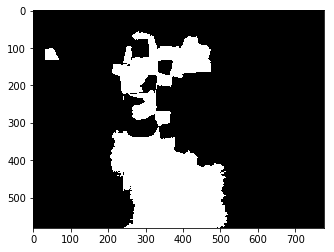

In [365]:
imshow(sal, cmap="gray")

In [17]:
def get_saliency_refined(image, saliency_initial):
    sift = cv.xfeatures2d.SIFT_create()
    segments = slic(image, n_segments = 400, compactness=20)
    medians = get_median_superpixel(1-saliency_initial/255, segments)
    sal, classes = classify_superpixels_based_on_median_of_saliency(1 - saliency_initial/255, segments, medians)
    descs = get_descriptor_for_each_superpixel(image, segments, sift, 40)
    new_fg, new_bg = clusterize_superpixels(descs, classes)
    fg, bg = get_indices_of_fg_bg_superpixels(classes)

    return new_fg, new_bg, fg, bg

In [382]:
new_fg, new_bg, fg, bg = get_saliency_refined(image, saliency)

424.6202506340468 424.48674890978634


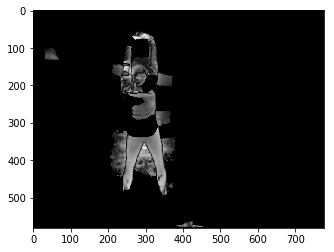

In [431]:
sal = color_saliency(fg, bg, segments, 1 - saliency/255)
imshow(sal, cmap="gray")

In [413]:
ret2,th2 = cv.threshold((sal * 255).astype(np.uint8),0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)

In [405]:
th2.shape

(581, 777)

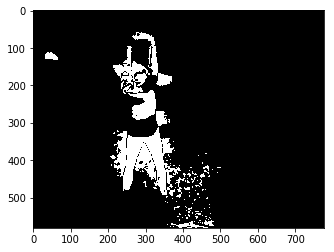

In [414]:
imshow(th2,cmap="gray")

In [19]:
from skimage.filters import threshold_otsu

In [394]:
threshold_otsu(sal)

0.224609375

In [18]:
def trimap_gen(im):
    kernel_erosion = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2, 2))
    kernel_dilation = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    dilated = cv.dilate(im, kernel_dilation, iterations=10)
    eroded = cv.erode(im, kernel_erosion, iterations=10)
    unknown = dilated - eroded
    print(np.unique(eroded))
    return eroded + unknown * (128 / 255)

[0 1]


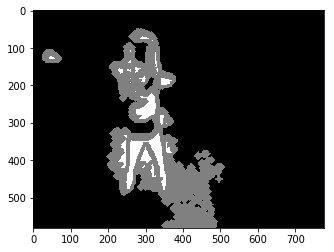

In [430]:
imshow(trimap_gen(th2),cmap="gray")

In [477]:
len(fg)

27

Try color histograms

In [478]:
x = np.empty((27, 27))
i_count = 0
for i in fg:
    j_count=0
    for j in fg:
        if i < j:
            hist = cv.calcHist(images=[image],channels=[0, 1, 2], mask=(segments==i).astype(np.uint8), histSize=[32, 32, 32], ranges=[0, 256, 0, 256, 0, 256]) 
            hist2 = cv.calcHist(images=[image],channels=[0, 1, 2], mask=(segments==j).astype(np.uint8), histSize=[32, 32, 32], ranges=[0, 256, 0, 256, 0, 256])
            dist = cv.compareHist(hist, hist2, cv.HISTCMP_BHATTACHARYYA)
            x[i_count, j_count] = dist
            x[j_count, i_count] = dist
        j_count += 1
    i_count += 1
            #             
#print(i, j, dist)

In [481]:
np.where(np.average(x, axis=1) < 0.86)[0]

(array([13, 15, 19, 20], dtype=int64),)

In [462]:
hist = cv.calcHist(images=[image],channels=[0, 1, 2], mask=(segments==50).astype(np.uint8), histSize=[32, 32, 32], ranges=[0, 256, 0, 256, 0, 256])

In [467]:
hist2 = cv.calcHist(images=[image],channels=[0, 1, 2], mask=(segments==250).astype(np.uint8), histSize=[32, 32, 32], ranges=[0, 256, 0, 256, 0, 256])

In [511]:
fg

array([ 50,  62,  79,  84,  90,  93, 111, 120, 133, 155, 158, 178, 184,
       219, 223, 228, 234, 244, 247, 250, 254, 270, 271, 274, 288, 302,
       377], dtype=int64)

In [468]:
cv.compareHist(hist, hist2, cv.HISTCMP_BHATTACHARYYA)

0.999445643854544

In [20]:
import warnings
def per_color_bhatt_d(ps, qs):
    # ps and qs contains per color histogram
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        distances = []
        for i in range(len(ps)):
            distances.append(sum(np.sqrt(ps[i] * qs[i])))
        distance = (sum(distances) / len(distances))#[0]
        if distance > 1:
            distance = 1
        
        if distance < 0:
            distance = 0
        try:
            return np.sqrt(1 - distance)
        except Warning:
            print(distance)
            return 1

In [561]:
hist_r = cv.calcHist(images=[image],channels=[0], mask=(segments==90).astype(np.uint8), histSize=[32], ranges=[0, 256])
hist_g = cv.calcHist(images=[image],channels=[1], mask=(segments==90).astype(np.uint8), histSize=[32], ranges=[0, 256])
hist_b = cv.calcHist(images=[image],channels=[2], mask=(segments==90).astype(np.uint8), histSize=[32], ranges=[0, 256])

hist2_r = cv.calcHist(images=[image],channels=[0], mask=(segments==156).astype(np.uint8), histSize=[32], ranges=[0, 256])
hist2_g = cv.calcHist(images=[image],channels=[1], mask=(segments==156).astype(np.uint8), histSize=[32], ranges=[0, 256])
hist2_b = cv.calcHist(images=[image],channels=[2], mask=(segments==156).astype(np.uint8), histSize=[32], ranges=[0, 256])

In [492]:
sum(np.sqrt(hist_r * hist2_r))

array([304.21588], dtype=float32)

In [21]:
def normalize_hists(hists):
    new_hists = []
    for hist in hists:
        new_hists.append(hist/(sum(hist)))
    return np.array(new_hists)

In [562]:
per_color_bhatt_d(normalize_hists([hist_r, hist_g, hist_b]), normalize_hists([hist2_r, hist2_g, hist2_b]))

0
1
2
0.91647404


0.289008573708519

In [554]:
segments[300, 250]

156

In [630]:
sal = 1 - saliency.copy()/255

In [629]:
fg[np.where(dbscan.labels_ == -1)]


array([ 84, 120, 158, 184], dtype=int64)

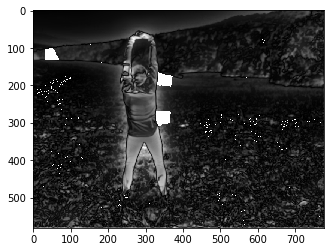

In [633]:
# np.where(dbscan.labels_ == -1)
sal = 1 - saliency.copy()/255
segment_indices = zip(*np.where(segments==84))
set_value_for_superpixel(sal, segment_indices, 1)
imshow(sal, cmap="gray")

In [22]:
def get_bhat_distance(image, segments, segment_a, segment_b):
    hist_r = cv.calcHist(images=[image],channels=[0], mask=(segments==segment_a).astype(np.uint8), histSize=[32], ranges=[0, 256])
    hist_g = cv.calcHist(images=[image],channels=[1], mask=(segments==segment_a).astype(np.uint8), histSize=[32], ranges=[0, 256])
    hist_b = cv.calcHist(images=[image],channels=[2], mask=(segments==segment_a).astype(np.uint8), histSize=[32], ranges=[0, 256])

    hist2_r = cv.calcHist(images=[image],channels=[0], mask=(segments==segment_b).astype(np.uint8), histSize=[32], ranges=[0, 256])
    hist2_g = cv.calcHist(images=[image],channels=[1], mask=(segments==segment_b).astype(np.uint8), histSize=[32], ranges=[0, 256])
    hist2_b = cv.calcHist(images=[image],channels=[2], mask=(segments==segment_b).astype(np.uint8), histSize=[32], ranges=[0, 256])
    return per_color_bhatt_d(normalize_hists([hist_r, hist_g, hist_b]), normalize_hists([hist2_r, hist2_g, hist2_b]))

In [23]:
def get_bhat_d_for_each_pair_superpixels(image, segments):
    n_segments = np.max(segments) + 1
    distances = np.empty((n_segments, n_segments))
    for i in range(n_segments):
        for j in range(n_segments):
            if i > j:
                continue
            d = get_bhat_distance(image, segments, i, j)
            distances[i, j] = d
            distances[j, i] = d
    return distances

In [24]:
def get_color_hist_for_each_superpixel(image, segments, hist_size=32):
    n_segments = np.max(segments) + 1
    hists_r = np.empty((n_segments, hist_size))
    hists_g = np.empty((n_segments, hist_size))
    hists_b = np.empty((n_segments, hist_size))
    for i in range(n_segments):
        hist_r = cv.calcHist(images=[image],channels=[0], mask=(segments==i).astype(np.uint8), histSize=[hist_size], ranges=[0, 256])
        hist_g = cv.calcHist(images=[image],channels=[1], mask=(segments==i).astype(np.uint8), histSize=[hist_size], ranges=[0, 256])
        hist_b = cv.calcHist(images=[image],channels=[2], mask=(segments==i).astype(np.uint8), histSize=[hist_size], ranges=[0, 256])
        hists_r[i] = normalize_hists([hist_r.reshape(hist_size)])
        hists_g[i] = normalize_hists([hist_g.reshape(hist_size)])
        hists_b[i] = normalize_hists([hist_b.reshape(hist_size)])
    return hists_r, hists_g, hists_b

In [48]:
hists = get_color_hist_for_each_superpixel(image, segments)

In [25]:
def get_average_hists_for_cluster(cluster_indices, hists):
    
    hist_r, hist_g, hist_b = hists
    hist_size = hist_r.shape[1]
    avg_r, avg_b, avg_g = np.zeros(hist_size), np.zeros(hist_size), np.zeros(hist_size)

    for index in cluster_indices:
        current_r = hist_r[index]
        current_g = hist_g[index]
        current_b = hist_b[index]
        avg_r += current_r
        avg_g += current_g
        avg_b += current_b
    avg_r /= len(cluster_indices)
    avg_g /= len(cluster_indices)
    avg_b /= len(cluster_indices)

    return avg_r, avg_g, avg_b
        

In [26]:
def get_average_hists_for_all_clusters(segment_indices, clusters, hists):
    #no avg hist for -1 cluster
    n_clusters = np.max(clusters) + 1
    all_hists = []
    for i in range(n_clusters):
        avg_hists = get_average_hists_for_cluster(segment_indices[np.where(clusters == i)], hists)
        all_hists.append(avg_hists)
    return all_hists

In [56]:
all_hists = get_average_hists_for_all_clusters(fg, dbscan.labels_, hists)

In [57]:
len(all_hists)

4

In [49]:
get_average_hists_for_cluster(fg[np.where(dbscan.labels_==0)], hists)

(array([0.00058481, 0.00265369, 0.00705195, 0.01919437, 0.0286117 ,
        0.0362133 , 0.04961681, 0.05900426, 0.07077641, 0.08216871,
        0.09488151, 0.09373522, 0.08775813, 0.06823409, 0.0450383 ,
        0.03467346, 0.02562534, 0.01838592, 0.0151921 , 0.01939128,
        0.0200946 , 0.04020668, 0.02313706, 0.01410698, 0.0110259 ,
        0.00978452, 0.01245411, 0.00456331, 0.00309801, 0.00181991,
        0.00057355, 0.000344  ]),
 array([0.00000000e+00, 1.05185654e-04, 5.25928258e-04, 7.45628909e-04,
        5.54022374e-03, 1.47871380e-02, 1.78951941e-02, 1.81068528e-02,
        1.53054460e-02, 1.43789476e-02, 1.23045608e-02, 1.21508556e-02,
        1.22702289e-02, 1.07010543e-02, 1.19593834e-02, 1.17707928e-02,
        1.38249015e-02, 1.72792275e-02, 1.84524717e-02, 2.27329980e-02,
        3.64293771e-02, 5.96644429e-02, 1.01237435e-01, 1.26488634e-01,
        1.52943075e-01, 1.36010670e-01, 8.11425731e-02, 5.67396795e-02,
        1.36401097e-02, 3.81512381e-03, 1.05185652e-03

In [27]:
def get_distance_one_to_all(hist, others):
    dists = []
    for hist_other in others:
        d= per_color_bhatt_d(hist, hist_other)
        dists.append(d)
    return dists

In [28]:
def clusterize_superpixels_hist(dists, classes, hists):
    fg, bg = get_indices_of_fg_bg_superpixels(classes)
    
    hist_shape = hists[0].shape
    hists_culture = np.array(list(zip(hists))).reshape(3, hist_shape[0], hist_shape[1])
    dbscan_fg = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)
    dbscan_bg = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)

    clusters_fg = dbscan_fg.fit_predict(dists[fg][:, fg])
    clusters_bg = dbscan_bg.fit_predict(dists[bg][:, bg])
    
    
    avg_hists_fg = get_average_hists_for_all_clusters(fg, clusters_fg, hists)
    avg_hists_bg = get_average_hists_for_all_clusters(bg, clusters_bg, hists)
    
#     t2_fg = mean_distance_to_every_center(descs[fg], cluster_centers_bg) 
#     t2_bg = mean_distance_to_every_center(descs[bg], cluster_centers_fg) 
    
#     print(mean_distance_to_every_center(descs[fg], cluster_centers_fg))
#     print(mean_distance_to_every_center(descs[bg], cluster_centers_bg))
    new_fg = []
    new_bg = []
#     print(t2_fg, t2_bg)
    new_bg += list(fg[np.where(clusters_fg==-1)])
    fg = np.delete(fg, np.where(clusters_fg==-1))
    bg = np.delete(bg, np.where(clusters_bg==-1))
    
    fg_hists = hists_culture[:,fg]
    bg_hists = hists_culture[:, bg]
    for index in range(fg_hists.shape[1]):
        point = fg_hists[:, index]

        dists_to_bg = get_distance_one_to_all(point, avg_hists_bg)
        dists_to_fg = get_distance_one_to_all(point, avg_hists_fg)

        if (np.min(dists_to_bg) < np.min(dists_to_fg)) and np.abs(np.min(dists_to_bg) - np.min(dists_to_fg)) > 0.1:
            print(np.min(dists_to_bg) , np.min(dists_to_fg), fg[index], index)
            new_bg.append(fg[index])
        else:
            new_fg.append(fg[index])

    for index in range(bg_hists.shape[1]):
        point = bg_hists[:, index]
        
        dists_to_bg = get_distance_one_to_all(point, avg_hists_bg)
        dists_to_fg = get_distance_one_to_all(point, avg_hists_fg)

        if (np.min(dists_to_bg) > np.min(dists_to_fg)) and np.abs(np.min(dists_to_fg) - np.min(dists_to_bg)) > 0.1:
            print(np.min(dists_to_bg) , np.min(dists_to_fg), bg[index], index)
            new_fg.append(bg[index])
#             print(np.min(dists_to_fg), np.min(dists_to_bg))
        else:
            new_bg.append(bg[index])
    return new_fg, new_bg

In [159]:
clusters_fg = np.array([ 0,  1,  1, -1,  1,  0,  0, -1,  1,  2, -1,  2, -1,  3,  0,  3,  0,
        0,  0,  3,  3,  0,  0,  3,  3,  3,  3])
clusters_bg = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
avg_hists_fg = get_average_hists_for_all_clusters(fg, clusters_fg, hists)
avg_hists_bg = get_average_hists_for_all_clusters(bg, clusters_bg, hists)
hist_shape = hists[0].shape
hists_culture = np.array(list(zip(hists))).reshape(3, hist_shape[0], hist_shape[1])
fg_hists = hists_culture[:,fg]
point = fg_hists[:, 10]

dists_to_bg = get_distance_one_to_all(point, avg_hists_bg)
dists_to_fg = get_distance_one_to_all(point, avg_hists_fg)


In [161]:
dists_to_bg

[0.7820471396175226, 0.7034103633232701, 0.31652095799785557]

In [28]:
dbscan  = DBSCAN()
# sift = cv.xfeatures2d.SIFT_create()
segments = slic(image, n_segments = 400, compactness=20)
medians = get_median_superpixel(1-saliency/255, segments)
sal, classes = classify_superpixels_based_on_median_of_saliency(1 - saliency/255, segments, medians)
# descs = get_descriptor_for_each_superpixel(image, segments, sift, 40)
dist = get_bhat_d_for_each_pair_superpixels(image, segments)
fg, bg = get_indices_of_fg_bg_superpixels(classes)
dbscan = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)
dbscan.fit(dist[fg][:, fg])
dbscan.labels_

array([ 0,  1,  1, -1,  1,  0,  0, -1,  1,  2, -1,  2, -1,  3,  0,  3,  0,
        0,  0,  3,  3,  0,  0,  3,  3,  3,  3], dtype=int64)

In [33]:
# sift = cv.xfeatures2d.SIFT_create()
segments = slic(image3, n_segments = 400, compactness=20)
medians = get_median_superpixel(saliency/255, segments)
sal, classes = classify_superpixels_based_on_median_of_saliency(saliency/255, segments, medians)
# descs = get_descriptor_for_each_superpixel(image, segments, sift, 40)
hists = get_color_hist_for_each_superpixel(image3, segments)
dist = get_bhat_d_for_each_pair_superpixels_fast(hists)
fg, bg = get_indices_of_fg_bg_superpixels(classes)
dbscan = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)
dbscan.fit_predict(dist[fg][:, fg])
# dbscan.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [162]:
dbscan = DBSCAN(eps=0.5,metric="precomputed",min_samples=2)
bg_classes = dbscan.fit_predict(dist[bg][:, bg])

In [108]:
hist_shape = hists[0].shape
hists_culture = np.array(list(zip(hists))).reshape(3, hist_shape[0], hist_shape[1])

In [111]:
hists_culture[:,fg][:, 0].shape

(3, 32)

In [34]:
fg, bg = get_indices_of_fg_bg_superpixels(classes)
new_fg, new_bg = clusterize_superpixels_hist(dist, classes, hists)


0.530716955577059 0.6730401612779703 34 2
0.47226388740020214 0.6447315954436043 48 5
0.37142546235021145 0.4844538079290886 88 14
0.5515747561835007 0.6534938496889374 110 21
0.5761516775543464 0.702632600824727 137 27
0.4788821933113103 0.610666193903553 141 28
0.422136635700255 0.5498084025766573 205 47
0.6528189204052217 0.7637584835810556 218 53
0.5094654521880324 0.6350772030498144 219 54
0.45383590173667904 0.6167570052829722 221 55
0.45850965665468085 0.5820206601495896 318 82
0.6239348508257794 0.5204937515997772 124 100
0.609540031742126 0.49011676226094475 166 129
0.6827850536852221 0.550756524010787 168 130
0.7201858762077851 0.5569933442281693 170 131
0.6549260093075475 0.5426762813410969 172 133
0.7396957012601588 0.5902426692719906 283 205
0.7320856919573077 0.5721792252768941 284 206
0.5760901301783357 0.42952063813436325 289 210
0.47115389809294667 0.37109297114663536 330 247
0.7610045756842456 0.5605971145805385 341 258


In [53]:
fg

array([ 50,  62,  67,  79,  90,  93, 129, 133, 154, 155, 156, 158, 178,
       193, 195, 200, 219, 220, 228, 250, 254, 274, 288, 302], dtype=int64)

In [104]:
67 in new_fg

False

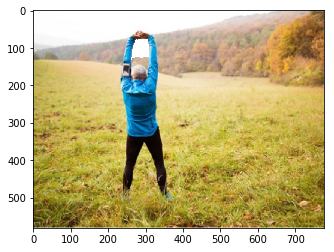

In [102]:
sal = cv.cvtColor(image.copy(), cv.COLOR_BGR2RGB)/255
segment_indices = zip(*np.where(segments==67))
set_value_for_superpixel(sal, segment_indices, 1)
imshow(sal, cmap="gray")

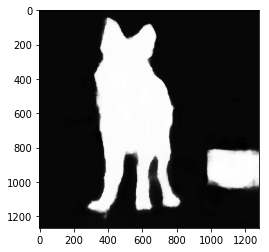

In [35]:
imshow(saliency, cmap="gray")

In [37]:
sal_colored = color_saliency(new_fg, new_bg, segments, saliency/255)

In [43]:
ret2,th2 = cv.threshold((saliency).astype(np.uint8),0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)

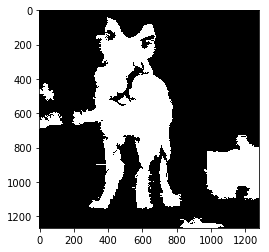

In [38]:
imshow(sal_colored, cmap="gray")

In [41]:
th2.shape

(1268, 1280)

[0 1]


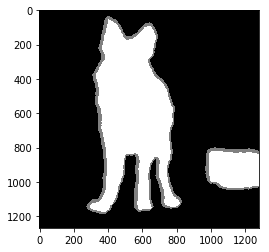

In [44]:
imshow(trimap_gen(th2), cmap="gray")

In [8]:
from matplotlib.pyplot import imsave

In [51]:
saliency[saliency<128] = 0

In [47]:
imsave(r"C:\Users\thalv\Desktop\trimap_dog.jpg", trimap_gen(th2), cmap="gray")

[0 1]


In [44]:
imsave("C:\Users\thalv\Desktop\trimap_person.jpg")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-44-b3217e39c12e>, line 1)

In [164]:
bg[bg_classes==2]

array([154, 193, 200, 220], dtype=int64)

In [4]:
# from trimap import generate_trimap
import tensorflow as tf
from scipy import misc

In [5]:
def tryit(path_img):
    base = "C:\\Workspace\\SalienceModel\\Salient-Object-Detection\\"
    g_mean = np.array(([126.88,120.24,112.19])).reshape([1,1,3])

    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 1)
    with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
        saver = tf.train.import_meta_graph(base + 'meta_graph\my-model.meta')
        saver.restore(sess,tf.train.latest_checkpoint(base + 'salience_model'))
        image_batch = tf.get_collection('image_batch')[0]
        pred_mattes = tf.get_collection('mask')[0]

        rgb = misc.imread(path_img)
        origin_shape = rgb.shape[:2]

        rgb = np.expand_dims(misc.imresize(rgb.astype(np.uint8),[320,320,3],interp="nearest").astype(np.float32)-g_mean,0)
        feed_dict = {image_batch:rgb}
        pred_alpha = sess.run(pred_mattes,feed_dict = feed_dict)
        final_alpha = misc.imresize(np.squeeze(pred_alpha),origin_shape)
        return final_alpha


In [6]:
saliency = tryit("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\beach-747750_1280_15.jpg")

INFO:tensorflow:Restoring parameters from C:\Workspace\SalienceModel\Salient-Object-Detection\salience_model\model.ckpt-200


C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [9]:
imsave("C:\\Users\\thalv\\Desktop\\dog_saliency.jpg", saliency, cmap="gray")